# Análisis de las vecindades de los píxeles tras la transformación LBP

En primer lugar se realiza la carga de la imagen sobre la que se va a realizar el proceso y se indican los parámetros seleccionados.

In [1]:
from preprocess.preprocess import *
import PARAMETERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from confusion_matrix_pretty_print import print_confusion_matrix
from main import init_clf_and_fit
import zipfile
from pathlib import Path
from joblib import Parallel, delayed


%matplotlib inline

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

LBP_METHOD               METHOD INTERPOLATION_ALGORITHM  BALANCE  \
Parameters    default  get_pyramid_dataset                 lanczos    False   

            N_SCALES  GRAY_INTENSITY  X2SCALE  
Parameters         5            True     True

In [2]:
def generate_kernels(seed=0):
    np.random.seed(seed)
    kernel_list = [np.round(np.random.uniform(low=-1, high=1, size=(9,)).reshape(3, 3), 3) for _ in range(5)]
    kernel_list += [np.round(np.random.uniform(low=-1, high=1, size=(25,)).reshape(5, 5), 3) for _ in range(5)]
    return kernel_list
    
kernel_list = generate_kernels()

In [3]:
def convolution_features(kernel):
    from create_db import main
    PARAMETERS.LBP_METHOD = 'default'
    PARAMETERS.METHOD = 'get_pyramid_dataset'
    PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
    PARAMETERS.BALANCE = False
    PARAMETERS.N_SCALES = 5
    PARAMETERS.GRAY_INTENSITY = True
    PARAMETERS.X2SCALE = True
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    PARAMETERS.PLOT = False
    PARAMETERS.CONVOLUTION = kernel
    PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
    PARAMETERS.DATASET = 'DRIVE'
    main()
    return f"../DB/{PARAMETERS.DATASET}/extra_features/convolution/{PARAMETERS.CONV_PATH}"
    
def generate_features(kernel_list):
    return Parallel(n_jobs=5)(delayed(convolution_features)(kernel) for kernel in kernel_list)

paths = generate_features(kernel_list)

In [4]:
def get_features(paths):
    for i, path in enumerate(paths):
        train_path = list(Path(path).glob('train_train*'))[0]
        test_path = list(Path(path).glob('train_test*'))[0]
        if i == 0:
            df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
            df_train_convolutions.drop(['label'], axis=1, inplace=True)
            df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
            df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
            df_test_convolutions.drop(['label'], axis=1, inplace=True)
            df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
        else:
            df_temp = pd.read_pickle(train_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
            df_temp = pd.read_pickle(test_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)
    return df_train_convolutions, df_test_convolutions

df_train_convolutions, df_test_convolutions = get_features(paths)

In [5]:
df_train_convolutions

Original_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927  \
0                                                     251                
1                                                     251                
2                                                     252                
3                                                     252                
4                                                     252                
...                                                   ...                
226537                                                  2                
226538                                                  2                
226539                                                  2                
226540                                                  2                
226541                                                  2                

        1:1_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927  \
0                                                     255           
1                                                     239           
2                                                     239           
3                                                     239           
4                                                     238           
...                                                   ...           
226537                                                 22           
226538                                                 30           
226539                                                 30           
226540                                                 30           
226541                                                 30           

        1:2_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927  \
0                                                     255           
1                                                     255           
2                                                     255           
3                                                     255           
4                                                     255           
...                                                   ...           
226537                                                 30           
226538                                                 30           
226539                                                 30           
226540                                                 30           
226541                                                 31           

        1:4_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927  \
0                                                     241           
1                                                     241           
2                                                     241           
3                                                     241           
4                                                     241           
...                                                   ...           
226537                                                 31           
226538                                                 31           
226539                                                 15           
226540                                                 15           
226541                                                 15           

        1:8_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927  \
0                                                     224           
1                                                     224           
2                                                     224           
3                                                     224           
4                                                     224           
...                                                   ...           
226537                                                 16           
226538                                                 16           
226539     

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


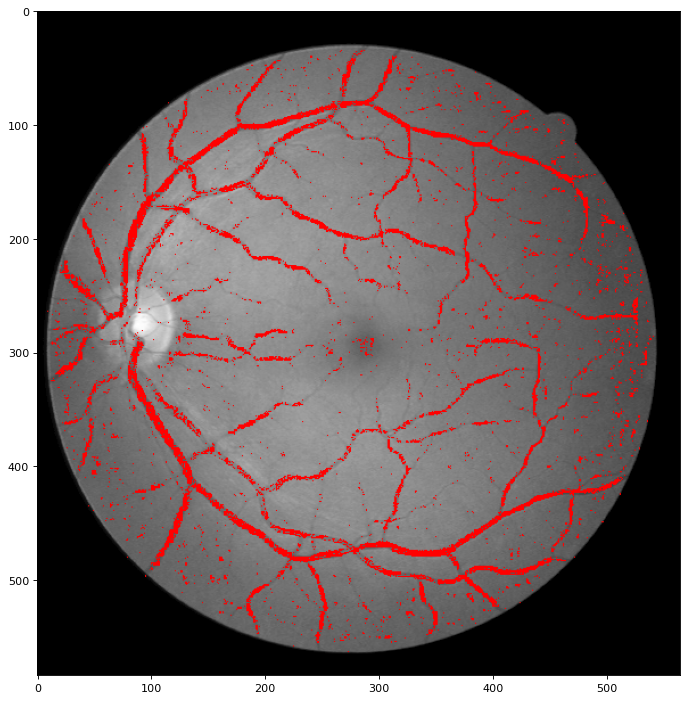

Accuracy score: 0.9072463853198083

F1 score: 0.5528685943922853

Confusion matrix:

     t/p      0     1 
        0 1158168 29377 
        1 97019 78143 
Sensivity: 0.44611845034882
Specificity: 0.9752624111086317


(0.907, 0.553, 1158168, 29377, 97019, 78143)

In [6]:
from main import *

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = True
PARAMETERS.DATASET = 'DRIVE'

PARAMETERS.CONVOLUTION = None
main(lgb='Num', plot_once=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


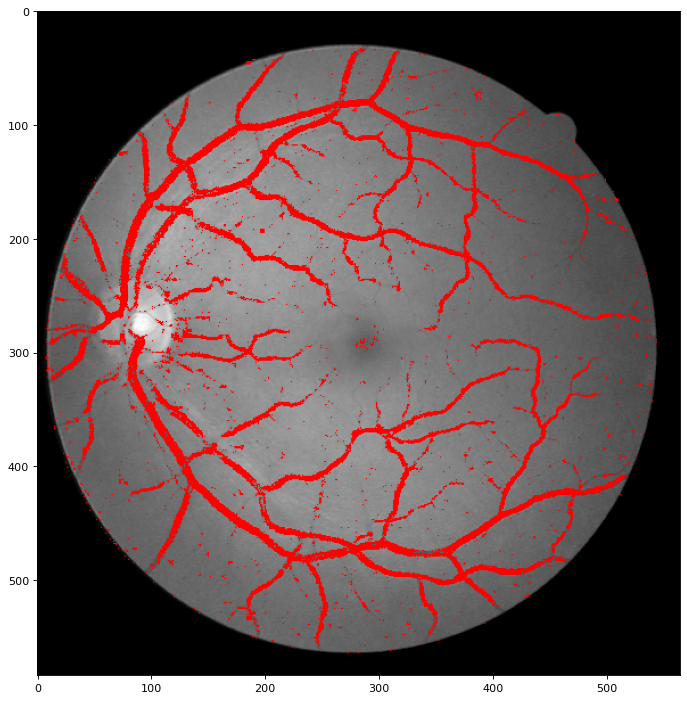

Accuracy score: 0.9281987984210839

F1 score: 0.6999000116550831

Confusion matrix:

     t/p      0     1 
        0 1150766 36779 
        1 61065 114097 
Sensivity: 0.6513798654959408
Specificity: 0.9690293841496532


(0.928, 0.7, 1150766, 36779, 61065, 114097)

In [7]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.705673 seconds.
You can set `force_col_wise=true` to remove the overhead.


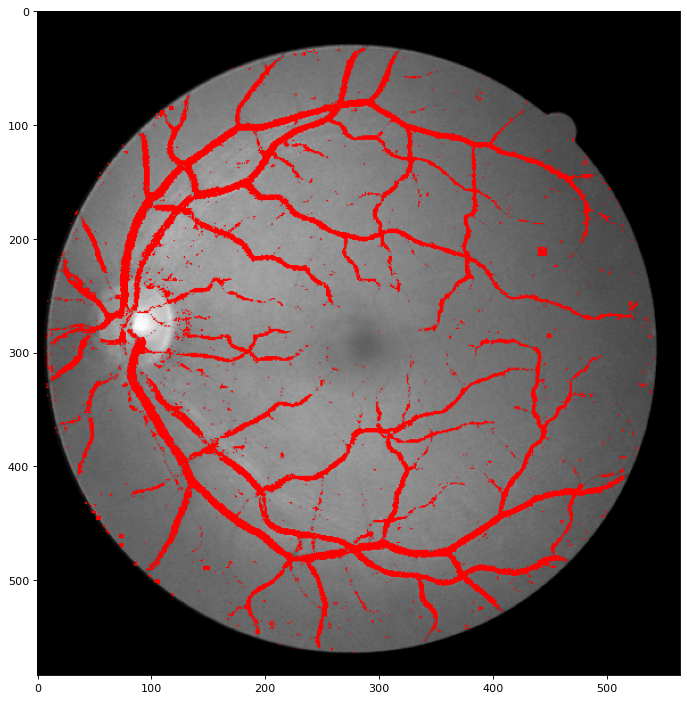

Accuracy score: 0.9326553690558572

F1 score: 0.7289060353715132

Confusion matrix:

     t/p      0     1 
        0 1147561 39984 
        1 51787 123375 
Sensivity: 0.7043479750174124
Specificity: 0.9663305390532569


(0.933, 0.729, 1147561, 39984, 51787, 123375)

In [8]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions}, all_lbp=True)

## Filtros de detección de bordes

In [30]:
 #from preprocess.preprocess import *

# convolution_features(kernel)

import cv2

'''laplacian = cv2.Laplacian(np.ones((5, 5)), cv2.CV_64F)
laplacian
cv2.CV_64F'''

kernel_list = []
# https://dsp.stackexchange.com/questions/44928/what-does-derivative-means-in-image-processing/44930
# LAPLACIAN
kernel_list.append(np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]))
kernel_list.append(np.array([[-1, 2, -1], [2, -8, 2], [-1, 2, -1]]))
#kernel_list.append(np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])) # 0.7220 -> 0.7224 

# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d
# SCHARR
kernel_list.append(np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]))
kernel_list.append(np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]))

# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
# SOBEL
kernel_list.append(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
kernel_list.append(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))

paths = generate_features(kernel_list)
df_train_edges, df_test_edges = get_features(paths)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.487250 seconds.
You can set `force_col_wise=true` to remove the overhead.


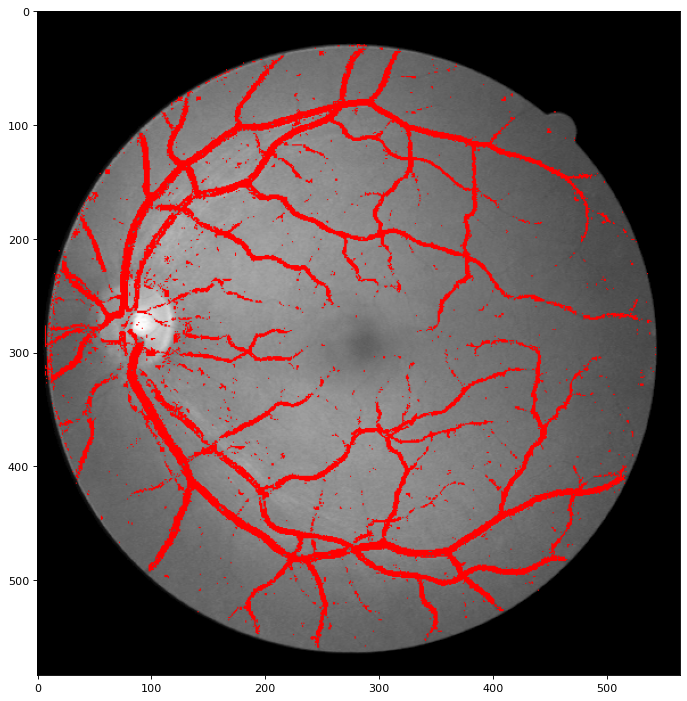

Accuracy score: 0.9302241787853148

F1 score: 0.7224521725931591

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1143872 43673 
      1.0 51411 123751 
Sensivity: 0.7064945593222274
Specificity: 0.9632241304540039


(0.93, 0.722, 1143872, 43673, 51411, 123751)

In [31]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_edges, 'test': df_test_edges})

## Utilización de diferentes núcleos de convolución

In [9]:
def convolution(seed=0):
    kernel_list = generate_kernels(seed)
    paths = generate_features(kernel_list)
    return get_features(paths)

In [10]:
df_train_convolutions1, df_test_convolutions1 = convolution(seed=1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.644862 seconds.
You can set `force_col_wise=true` to remove the overhead.


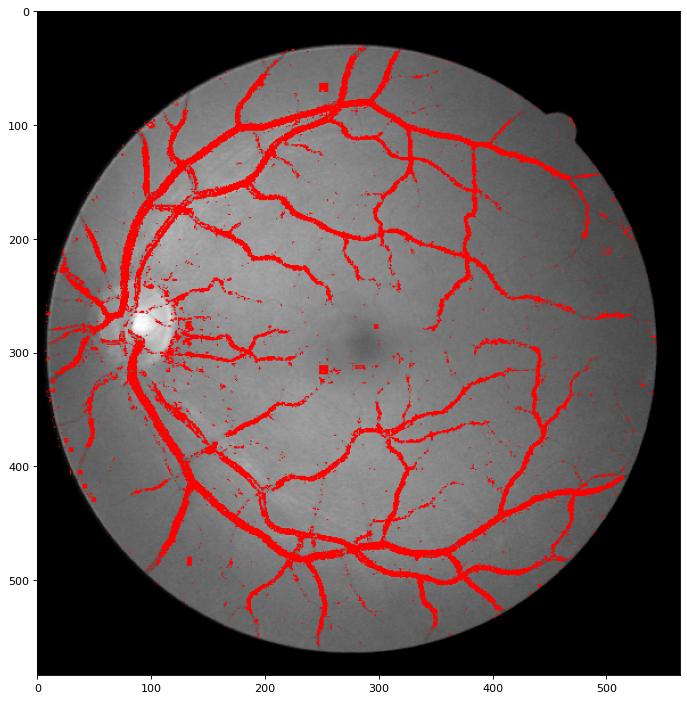

Accuracy score: 0.9224690267240133

F1 score: 0.6843193498267001

Confusion matrix:

     t/p      0     1 
        0 1142541 45004 
        1 60648 114514 
Sensivity: 0.6537605188339937
Specificity: 0.9621033308211479


(0.922, 0.684, 1142541, 45004, 60648, 114514)

In [11]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions1, 'test': df_test_convolutions1})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.635591 seconds.
You can set `force_col_wise=true` to remove the overhead.


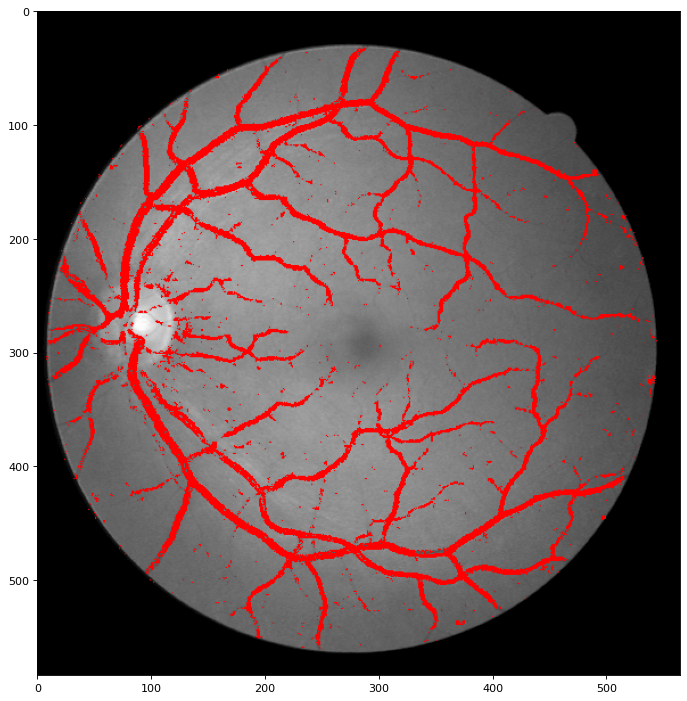

Accuracy score: 0.9305008340017333

F1 score: 0.7179736099985409

Confusion matrix:

     t/p      0     1 
        0 1147449 40096 
        1 54611 120551 
Sensivity: 0.6882257567280574
Specificity: 0.9662362268377198


(0.931, 0.718, 1147449, 40096, 54611, 120551)

In [12]:
df_train_conv01 = pd.concat([df_train_convolutions, df_train_convolutions1], axis=1)
df_test_conv01 = pd.concat([df_test_convolutions, df_test_convolutions1], axis=1)
main(lgb='Num', plot_once=True, extra_features={'train': df_train_conv01, 'test': df_test_conv01})

In [13]:
df_train_convolutions2, df_test_convolutions2 = convolution(seed=2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


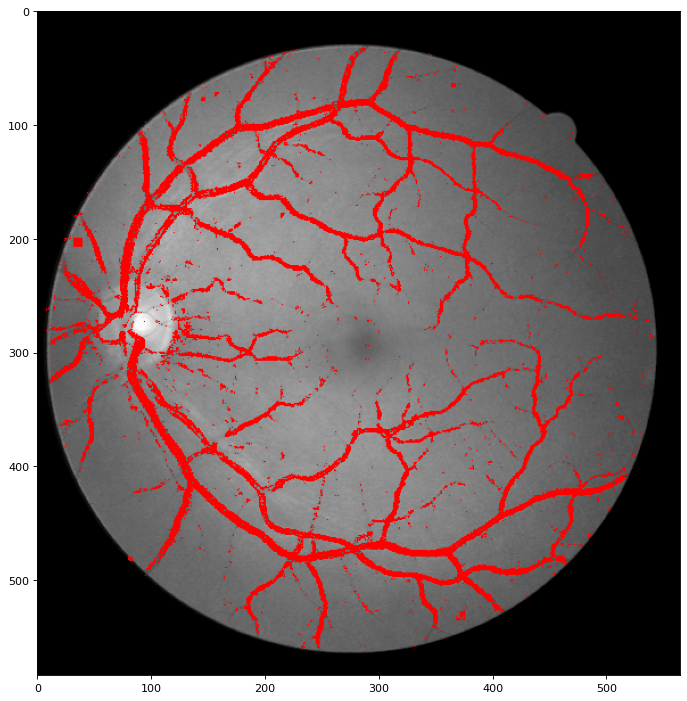

Accuracy score: 0.9269630228655169

F1 score: 0.701079415421765

Confusion matrix:

     t/p      0     1 
        0 1146464 41081 
        1 58447 116715 
Sensivity: 0.6663260296182962
Specificity: 0.9654067845850052


(0.927, 0.701, 1146464, 41081, 58447, 116715)

In [14]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions2, 'test': df_test_convolutions2})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.792530 seconds.
You can set `force_col_wise=true` to remove the overhead.


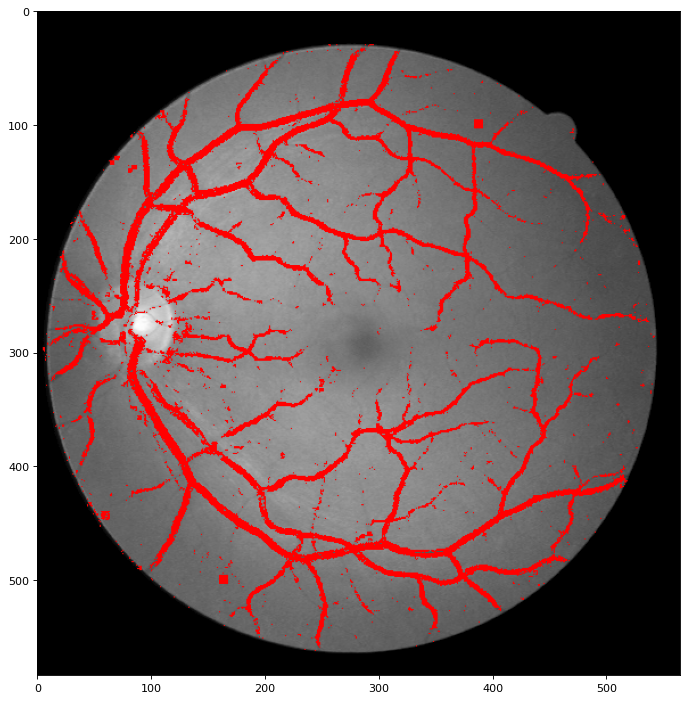

Accuracy score: 0.9317887117333367

F1 score: 0.7255332719155267

Confusion matrix:

     t/p      0     1 
        0 1146899 40646 
        1 52306 122856 
Sensivity: 0.7013850035966706
Specificity: 0.9657730864935644


(0.932, 0.726, 1146899, 40646, 52306, 122856)

In [15]:
df_train_conv012 = pd.concat([df_train_conv01, df_train_convolutions2], axis=1)
df_test_conv012 = pd.concat([df_test_conv01, df_test_convolutions2], axis=1)
main(lgb='Num', plot_once=True, extra_features={'train': df_train_conv012, 'test': df_test_conv012})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.539790 seconds.
You can set `force_col_wise=true` to remove the overhead.


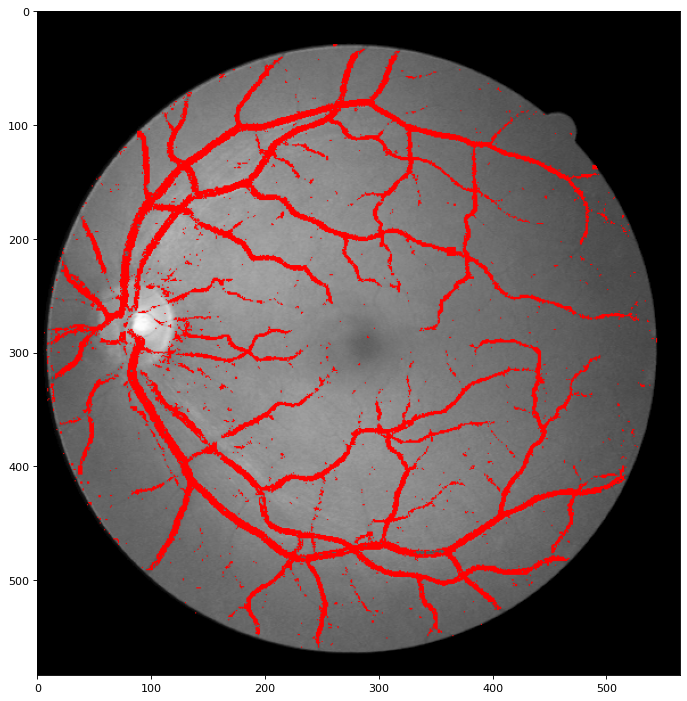

Accuracy score: 0.9326040007132861

F1 score: 0.7296798518906603

Confusion matrix:

     t/p      0     1 
        0 1146912 40633 
        1 51208 123954 
Sensivity: 0.707653486486795
Specificity: 0.9657840334471536


(0.933, 0.73, 1146912, 40633, 51208, 123954)

In [21]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_conv012, 'test': df_test_conv012}, all_lbp=True)

In [94]:
with open(f"../models/lbm_fit_convolutions.pkl", 'rb') as f:
    clf = pickle.load(f)

In [67]:
db_path = f"../DB"

columns = []
for i, lbp_operator in enumerate(['default', 'riu', 'riu2', 'nriuniform', 'var']):
    PARAMETERS.LBP_METHOD = lbp_operator
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    train_file_name = f"{db_path}/train_train_{PARAMETERS.FILE_EXTENSION}"
    new_columns = list(pd.read_pickle(f'{train_file_name}.pkl', compression='gzip').columns)
    new_columns.remove('label')
    if 'Original' in columns and 'Original' in new_columns:
        new_columns.remove('Original')
    columns += new_columns
columns += list(df_train_conv012.columns)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, columns)), columns=['Value','Feature'])

In [69]:
feature_imp

Value                                            Feature
0        0  1:1_-0.128;-0.948;0.099;-0.129;-0.159;-0.339;-...
1        0  1:1_-0.166;0.441;-1.0;-0.395;-0.706;-0.815;-0....
2        0  1:1_-0.786;-0.559;-0.3;-0.064;-0.597;0.281;-0....
3        0  1:1_0.078;-0.162;0.37;-0.591;0.756;-0.945;0.34...
4        0  1:1_0.096;0.399;-0.508;-0.627;-0.779;-0.452;-0...
..     ...                                                ...
306     66  1:8_0.556;0.74;0.957;0.598;-0.077;0.561;-0.763...
307     94                                                1:4
308     98                                                1:2
309    109                                                1:8
310    124                                                1:1

[311 rows x 2 columns]

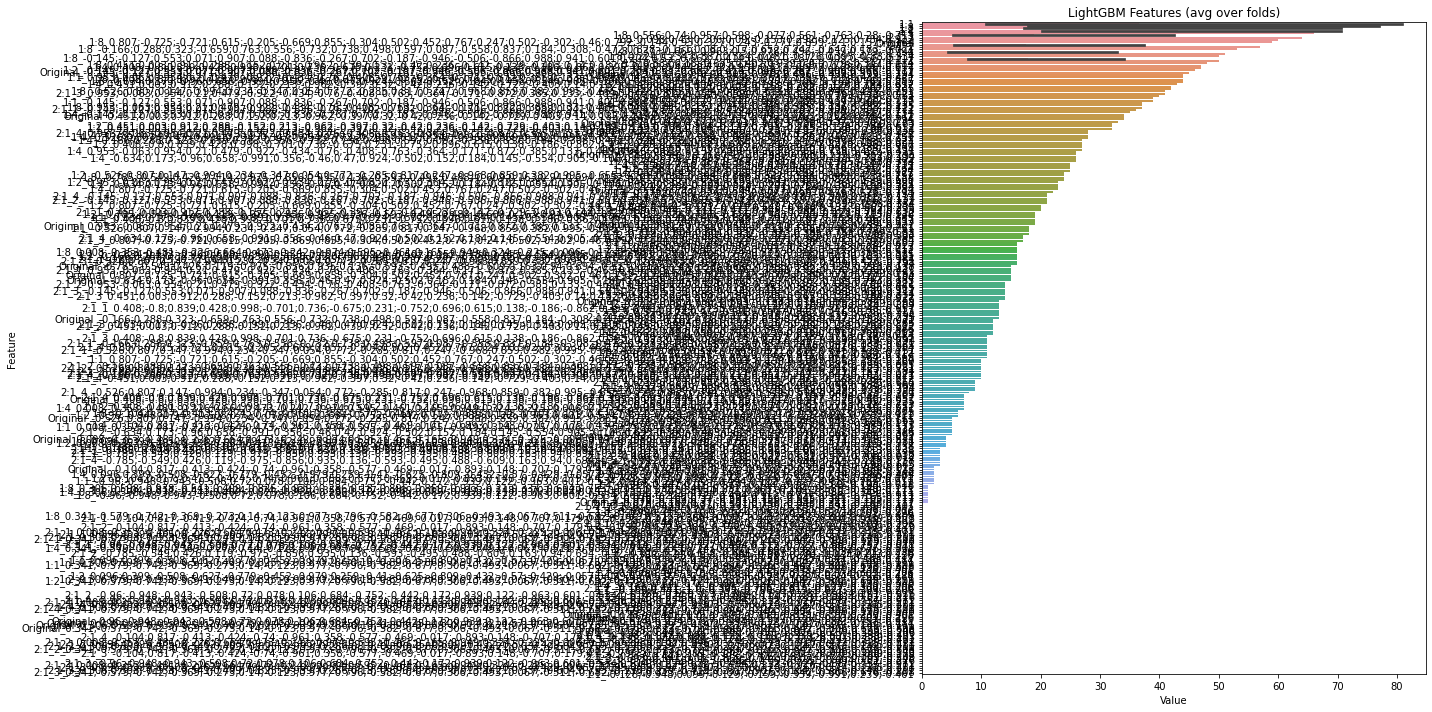

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [77]:
feature_imp['Convolution'] = feature_imp['Feature'].str.split('_').str[-1]
feature_imp['Convolution'] = [c if ';' in c else 'None' for c in feature_imp['Convolution']]

In [78]:
conv_imp = feature_imp.groupby("Convolution")["Value"].sum().to_frame().sort_values(by="Value", ascending=False)
conv_imp

Value
Convolution                                              
None                                                 1218
-0.145;-0.127;0.553;0.071;0.907;0.088;-0.836;-0...    310
0.953;-0.063;0.954;0.21;0.479;-0.922;-0.434;-0....    249
0.451;0.003;0.912;0.288;-0.152;0.213;-0.962;-0....    246
0.889;0.044;-0.171;-0.471;0.548;-0.088;0.137;-0...    238
0.587;0.16;-0.675;0.402;0.929;0.0;0.779;-0.317;...    231
0.373;0.669;-0.963;0.5;0.978;0.496;-0.439;0.579...    228
0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784...    225
0.224;0.234;0.887;0.364;-0.281;-0.126;0.395;-0....    221
0.556;0.74;0.957;0.598;-0.077;0.561;-0.763;0.28...    219
0.807;-0.725;-0.721;0.615;-0.205;-0.669;0.855;-...    184
0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.67...    182
-0.719;-0.604;0.601;0.937;-0.373;0.385;0.753;0....    179
-0.634;0.173;-0.96;0.658;-0.991;0.356;-0.46;0.4...    177
-0.526;0.807;0.147;-0.994;0.234;-0.347;0.054;0....    164
-0.166;0.288;0.323;-0.659;0.763;0.556;-0.732;0....    159
-0.922;-0.66;0.756;-0.803;-0.158;0.916;0.066;0....    109
-0.785;-0.549;0.426;0.119;-0.975;-0.856;0.935;0...    100
-0.233;0.583;0.058;0.136;0.851;-0.858;-0.826;-0...     95
-0.466;0.242;0.058;-0.731;0.027;-0.631;0.571;0....     55
0.078;-0.162;0.37;-0.591;0.756;-0.945;0.341;-0....     36
0.008;-0.353;-0.481;-0.226;0.664;0.473;-0.242;-...     36
-0.104;0.817;-0.413;-0.424;-0.74;-0.961;0.358;-...     16
-0.96;-0.948;-0.943;-0.508;0.72;0.078;0.106;0.6...      9
0.096;0.399;-0.508;-0.627;-0.779;-0.452;-0.979;...      6
0.693;-0.841;0.01;-0.869;-0.144;-0.807;-0.746;0...      4
0.306;0.598;-0.938;-0.541;0.409;-0.825;-0.939;-...      2
-0.128;-0.948;0.099;-0.129;-0.159;-0.339;-0.591...      2
0.341;-0.579;-0.742;-0.369;-0.273;0.14;-0.123;0...      0
-0.786;-0.559;-0.3;-0.064;-0.597;0.281;-0.034;0...      0
-0.166;0.441;-1.0;-0.395;-0.706;-0.815;-0.627;-...      0

In [87]:
cols_to_remove = []
for conv in list(conv_imp.index)[-3:]:
    for c in columns:
        if conv in c:
            cols_to_remove.append(c)
    
df_train_temp = df_train_conv012.drop(columns=cols_to_remove, inplace=False)
df_test_temp = df_test_conv012.drop(columns=cols_to_remove, inplace=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.351901 seconds.
You can set `force_col_wise=true` to remove the overhead.


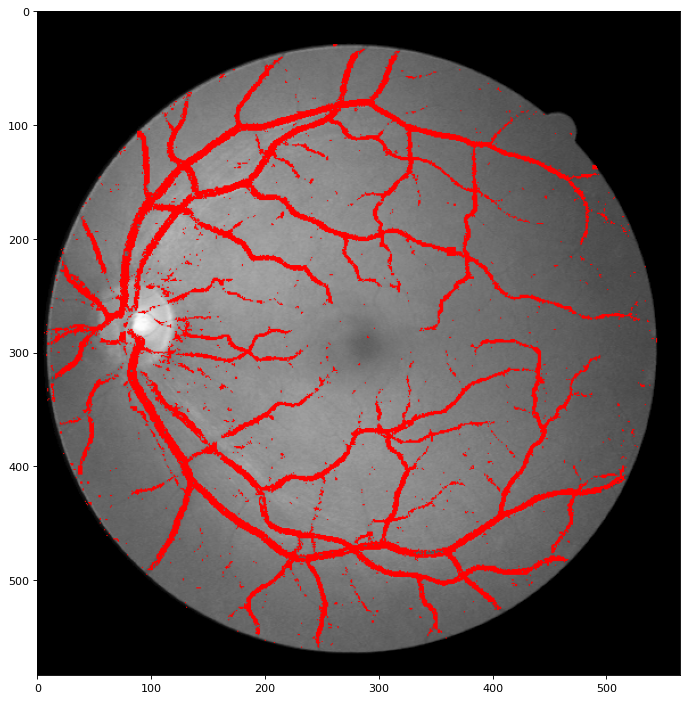

Accuracy score: 0.9327397599043669

F1 score: 0.7301918117913032

Confusion matrix:

     t/p      0     1 
        0 1147025 40520 
        1 51136 124026 
Sensivity: 0.7080645345451639
Specificity: 0.9658791877360436


(0.933, 0.73, 1147025, 40520, 51136, 124026)

In [88]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_temp, 'test': df_test_temp}, all_lbp=True)

In [93]:
cols_to_remove = []
for conv in list(conv_imp.index)[1:4]:
    for c in columns:
        if conv in c:
            cols_to_remove.append(c)
    
df_train_temp = df_train_conv012.drop(columns=cols_to_remove, inplace=False)
df_test_temp = df_test_conv012.drop(columns=cols_to_remove, inplace=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.932296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


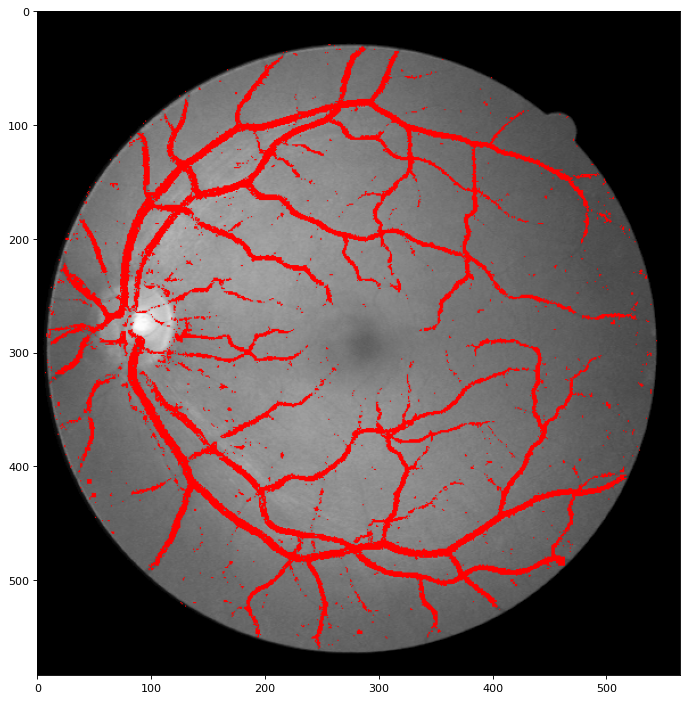

Accuracy score: 0.9322811139885536

F1 score: 0.7283735852944206

Confusion matrix:

     t/p      0     1 
        0 1146699 40846 
        1 51435 123727 
Sensivity: 0.7063575433027711
Specificity: 0.9656046718229625


(0.932, 0.728, 1146699, 40846, 51435, 123727)

In [95]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_temp, 'test': df_test_temp}, all_lbp=True)